$\textbf{Import Packages}$

In [1]:
import numpy as np
import pandas as pd
import spacy

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import string

import random
random.seed(123)

$\textbf{Import Labelled Data}$

In [2]:
# load group concatenated data
data = pd.read_csv('../../events/group_all_labelled.csv')
df = data.loc[data.reviewed].reset_index(drop=True)  # had a missing index

$\textbf{Define utility functions and vectorizers}$

In [3]:
# gensim Doc2Vec Implementation from Feature Extraction Group
import gensim 
from gensim.models import Word2Vec 
from gensim.models.phrases import Phrases, Phraser
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def get_tokens(doc):
    return [w.lemma_ for w in nlp(doc) if (w.is_alpha and not w.is_stop)]

def load_model_vectors(df, max_epochs = 100, vec_size = 20, alpha = 0.025, model_path="d2v.model"):
    tagged_data = [TaggedDocument(words=row.tokens, tags=[row.event_id]) for row in df.itertuples()]
    model = Doc2Vec(size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm =1)
    model.build_vocab(tagged_data)
    for epoch in range(max_epochs):
        model.train(tagged_data, total_examples=model.corpus_count, epochs=model.iter)
        model.alpha -= 0.0002
        model.min_alpha = model.alpha
        
    model.save(model_path)
    return get_doc2vec(model, df)

def get_doc2vec(model, df):
    vecs = []
    for event_id in df['event_id']:
        try:
            vec = model.docvecs[event_id]
        except:
            vec = np.nan
        vecs.append(vec)
        
    return vecs

def to_list(x):
    if isinstance(x, str):
        return x.split(',')
    else:
        return ['unknown']

In [4]:
# load base spacy model
nlp = spacy.load('en_core_web_lg')

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# custom spacy tokenizer tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens


# bag of words vectorizer
bow_vec = CountVectorizer(
    min_df=3, # min document frequency count
    tokenizer = spacy_tokenizer,
    analyzer="word",
    ngram_range=(1,3),
    stop_words="english") # note we have a tokenizer that also cleans the data - not sure if necessary here

# term frequency - inverse document frequency vectorizer
tf_idf_vec = TfidfVectorizer(
    min_df=3,
    tokenizer = spacy_tokenizer,
    max_features = 60_000, #100_000,
    analyzer="word",
    ngram_range=(1,3), # (1,6)
    stop_words="english") # note we have a tokenizer that also cleans the data - not sure if necessary here

# document 2 vec model
doc2vec_model = Doc2Vec.load('d2v.model')

# create a dictionary of these vectorizers to be called later
vectorizers = {'bow': bow_vec, 'tfidf': tf_idf_vec, 'doc2vec': doc2vec_model}

In [5]:
# get labels from data
labels = df['Near Miss Event'].astype(int)

# computes vectorised data and stores in dictionary (may take some time)
vectors = {}
vectors['doc2vec'] = pd.DataFrame((get_doc2vec(vectorizers['doc2vec'], df)))
vectors['bow'] = pd.DataFrame(vectorizers['bow'].fit_transform(df.event_text).toarray())  # converts from sparse matrix
vectors['tfidf'] = pd.DataFrame(vectorizers['tfidf'].fit_transform(df.event_text).toarray())

$\textbf{Perform stratified sampling and calculate mean vectors}$

In [6]:
# stratified sampling with indices (instead of data) and labels
train_idx, test_idx, train_labels, test_labels = train_test_split(
    df.index, labels, test_size=0.3, stratify=labels.values)

# take sampled indices and subset for all vectorised dataframes
train = {vectorizer : vector_data.loc[train_idx] for vectorizer, vector_data in vectors.items()}
test = {vectorizer : vector_data.loc[test_idx] for vectorizer, vector_data in vectors.items()}

print(f'Class balance for train set:\n{train_labels.value_counts()}\n')
print(f'Class balance for test set:\n{test_labels.value_counts()}')

# compute the "mean" vector for each vectorised input  - mean vector will depend on vectorisation
mean_vectors = {vectorizer : train[vectorizer].mean(axis=0) for vectorizer in vectors.keys()}

Class balance for train set:
0    871
1    298
Name: Near Miss Event, dtype: int64

Class balance for test set:
0    374
1    127
Name: Near Miss Event, dtype: int64


$\textbf{Test Cosine Classification}$

In [24]:
# define cosine classification functions
def cosine_similarity(a, b):
    magnitude = lambda x : np.sqrt(np.sum(np.power(x,2)))
    return (np.dot(a, b)) / (magnitude(a)*magnitude(b))

def cosine_distance(a, b):
    return 1 - cosine_similarity(a, b)

def cosine_classify(a, b, threshold = 0.5):
    return int(cosine_distance(a,b) > threshold)

# decimals = 4  # decimals for rounding
thresholds = np.linspace(0., 1.0, 101)

# create an empty results dictionary to store prediction scores for each vectorisation type
results = {}

# go through many potential thresholds so we can plot on x axis later, for each vectorizer type
for vectorizer in vectorizers.keys(): 
    data = [] # create empty list to store predictions for each threshold
    for threshold in thresholds:
        # calculate predictions for all thresholds given vectorised data
        predictions = [cosine_classify(vector_data, mean_vectors[vectorizer].values, threshold=threshold)
            for vector_data in test[vectorizer].values]
        
        # append prediction scores for a given vectorisation + threshold
        data.append({'accuracy': metrics.accuracy_score(test_labels, predictions),
        'precision' : metrics.precision_score(test_labels, predictions),
        'recall' : metrics.recall_score(test_labels, predictions),
        'f_score' : metrics.f1_score(test_labels, predictions)})
        
    # save the data to the results dictionary
    results[vectorizer] = data

# convert results from a dictionary where keys are vector types, values are lists of dictionaries to dataframe
results = {vector : pd.DataFrame(results[vector], index=thresholds) for vector in vectors.keys()}

/home/daniel/miniconda3/envs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


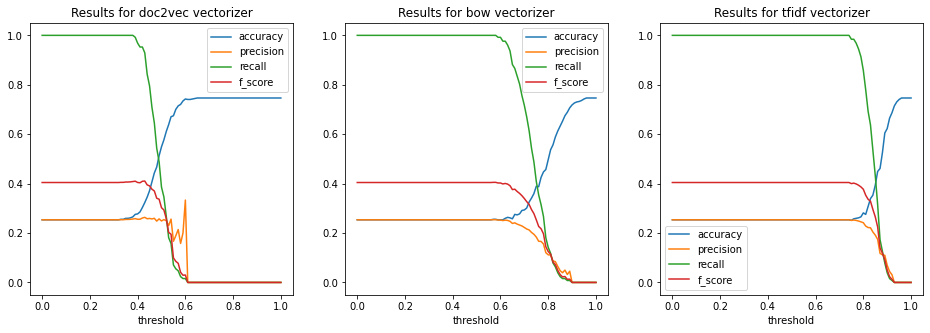

In [31]:
import matplotlib.pyplot as plt # for plotting these results

# instantiate figure with 3 column axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

# plot results to each of these axes
for idx, result in enumerate(results):
    results[result].plot(title = f'Results for {result} vectorizer', ax=axes[idx], xlabel='threshold')

In [27]:
# display results dataframe
for vectorizer, result in results.items():
    print(f' vectorizer method: {vectorizer}')
    display(result)

 vectorizer method: doc2vec


,accuracy,precision,recall,f_score
0.00,0.253493,0.253493,1.0,0.404459
0.01,0.253493,0.253493,1.0,0.404459
0.02,0.253493,0.253493,1.0,0.404459
0.03,0.253493,0.253493,1.0,0.404459
0.04,0.253493,0.253493,1.0,0.404459
...,...,...,...,...
0.96,0.746507,0.000000,0.0,0.000000
0.97,0.746507,0.000000,0.0,0.000000
0.98,0.746507,0.000000,0.0,0.000000
0.99,0.746507,0.000000,0.0,0.000000


 vectorizer method: bow


,accuracy,precision,recall,f_score
0.00,0.253493,0.253493,1.0,0.404459
0.01,0.253493,0.253493,1.0,0.404459
0.02,0.253493,0.253493,1.0,0.404459
0.03,0.253493,0.253493,1.0,0.404459
0.04,0.253493,0.253493,1.0,0.404459
...,...,...,...,...
0.96,0.746507,0.000000,0.0,0.000000
0.97,0.746507,0.000000,0.0,0.000000
0.98,0.746507,0.000000,0.0,0.000000
0.99,0.746507,0.000000,0.0,0.000000


 vectorizer method: tfidf


,accuracy,precision,recall,f_score
0.00,0.253493,0.253493,1.0,0.404459
0.01,0.253493,0.253493,1.0,0.404459
0.02,0.253493,0.253493,1.0,0.404459
0.03,0.253493,0.253493,1.0,0.404459
0.04,0.253493,0.253493,1.0,0.404459
...,...,...,...,...
0.96,0.746507,0.000000,0.0,0.000000
0.97,0.746507,0.000000,0.0,0.000000
0.98,0.746507,0.000000,0.0,0.000000
0.99,0.746507,0.000000,0.0,0.000000
